In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFoldfrom sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score



In [2]:
subs = pd.read_csv(r'C:\Users\Pysku\OneDrive\Рабочий стол\Headway\subscription_funnel (1).csv')
event = pd.read_csv(r'C:\Users\Pysku\OneDrive\Рабочий стол\Headway\events (1).csv')
user = pd.read_csv(r"C:\Users\Pysku\OneDrive\Рабочий стол\Headway\users.csv")

In [3]:
subs.head()

,user_id,first_transaction,first_marketplace,first_subscription_type,trial_optin_at,trial_retention_at,first_autorenewal_off,revenue_d8
0,624641c9d32d7a000c2c1996,2022-04-08 00:14:34,recurly,yearly,2022-04-01 00:09:35.212,2022-04-08 00:14:34,NaN,88.57
1,624641d4d32d7a000cc01dd3,NaN,NaN,NaN,2022-04-01 00:07:50.646,NaN,2022-04-02 16:22:55.769,NaN
2,624649ffd32d7a000c88ac06,NaN,NaN,NaN,2022-04-01 00:43:20.381,NaN,2022-04-07 11:39:15.412,NaN
3,6246505fd32d7a000ce56c6f,2022-04-08 01:10:28,itunes,3-months,2022-04-01 01:10:32.74,NaN,NaN,16.75
4,624651b0d32d7a000f2b9ae7,2022-04-08 01:22:18,gp-android,yearly,2022-04-01 01:18:39.742,2022-04-08 01:22:18,NaN,62.52


In [4]:
# спочатку ми очищаємо кожен датасет окремо перед їх об'єднанням

In [5]:
subs.head()
subs.dtypes
subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194459 entries, 0 to 194458
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   user_id                  194459 non-null  object 
 1   first_transaction        86275 non-null   object 
 2   first_marketplace        86275 non-null   object 
 3   first_subscription_type  86275 non-null   object 
 4   trial_optin_at           182924 non-null  object 
 5   trial_retention_at       71838 non-null   object 
 6   first_autorenewal_off    121331 non-null  object 
 7   revenue_d8               75372 non-null   float64
dtypes: float64(1), object(7)
memory usage: 11.9+ MB


In [6]:
# Our main table is 'subs' - so we are going to start cleaning and aggregating data in this table first

In [7]:
# the task is to predict coversion rate to payment, but not to predict the sum amount.
# since that we can create binary value of our ['revenue_d8'] column
subs["converted"] = (subs["revenue_d8"].fillna(0) > 0).astype(int)

In [ ]:
subs = subs.drop(columns=[
    "first_transaction",       # may cause leackage - event after conversion
    "trial_retention_at",      # event after 7th day
    "first_autorenewal_off",   # event after trial
    "first_subscription_type", # may cause leackage - our target value may be interprated by this column causing high AUC 
    'first_marketplace',
    'revenue_d8'               # as long as we created binary value, we dont need it anymore  
], errors="ignore")


In [ ]:
# we finished with this table at this moment, so we can move on

subs.head()

,user_id,trial_optin_at,converted
0,624641c9d32d7a000c2c1996,2022-04-01 00:09:35.212,1
1,624641d4d32d7a000cc01dd3,2022-04-01 00:07:50.646,0
2,624649ffd32d7a000c88ac06,2022-04-01 00:43:20.381,0
3,6246505fd32d7a000ce56c6f,2022-04-01 01:10:32.74,1
4,624651b0d32d7a000f2b9ae7,2022-04-01 01:18:39.742,1


In [ ]:
# user table is showing the information about our user

user.head()

,user_id,signup_timestamp,country,signup_channel,signup_client_platform
0,62464111d32d7a000b5ddccf,2022-04-01 00:02:26,us,organic,iOS
1,62464120d32d7a000ec025d9,2022-04-01 00:02:40,us,gsn,Web
2,624641a2d32d7a0010e5a976,2022-04-01 00:04:50,fr,uac,Android
3,624641a5d32d7a0010aca26f,2022-04-01 00:04:53,mx,affiliate,Web
4,624642f2d32d7a000fdfe79d,2022-04-01 00:10:26,us,facebook,iOS


In [ ]:
# these columns are categorial. to know the variety of categories in each column important for further encoding.
# seems like OneHotEncoding and FrequencyEncoding would be the best options to operate with high cardinality data

print(user['country'].value_counts(normalize=True).count())
print(user['signup_channel'].value_counts(normalize=True).count())
print(user['signup_client_platform'].value_counts(normalize=True).count())

231
607
3


In [ ]:
print(user.shape)
print(user.info())
print(user.isnull().mean())

# there are low % of n/a values in these table (less then 1% in signup_channel and signup_channel_platform), 
# so we can change it with value "other"

(1087474, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1087474 entries, 0 to 1087473
Data columns (total 5 columns):
 #   Column                  Non-Null Count    Dtype 
---  ------                  --------------    ----- 
 0   user_id                 1087474 non-null  object
 1   signup_timestamp        1087474 non-null  object
 2   country                 1087474 non-null  object
 3   signup_channel          1087472 non-null  object
 4   signup_client_platform  1080190 non-null  object
dtypes: object(5)
memory usage: 41.5+ MB
None
user_id                   0.000000
signup_timestamp          0.000000
country                   0.000000
signup_channel            0.000002
signup_client_platform    0.006698
dtype: float64


In [13]:
user.fillna({
    'signup_channel': 'other',
    'signup_client_platform': 'other'
}, inplace=True)

In [ ]:
# the table is fine, so we can merge it

df1 = subs.merge(user, on="user_id", how="inner")
df1.head()

,user_id,trial_optin_at,converted,signup_timestamp,country,signup_channel,signup_client_platform
0,624641c9d32d7a000c2c1996,2022-04-01 00:09:35.212,1,2022-04-01 00:05:29,us,gsn,Web
1,624641d4d32d7a000cc01dd3,2022-04-01 00:07:50.646,0,2022-04-01 00:05:40,de,gsn,Android
2,624649ffd32d7a000c88ac06,2022-04-01 00:43:20.381,0,2022-04-01 00:40:31,us,organic,Web
3,6246505fd32d7a000ce56c6f,2022-04-01 01:10:32.74,1,2022-04-01 01:07:43,us,organic,iOS
4,624651b0d32d7a000f2b9ae7,2022-04-01 01:18:39.742,1,2022-04-01 01:13:20,us,uac,Android


In [15]:
# now we can move to the final table - 'event'

event.head()

,user_id,dim_date_id,is_bib_active,is_episode_active
0,6246877ed32d7a000fa73e8d,2022-04-01,True,False
1,62474f4ed32d7a000c8b5e06,2022-04-06,True,False
2,62474f4ed32d7a000c8b5e06,2022-04-04,True,False
3,62474f4ed32d7a000c8b5e06,2022-04-02,True,False
4,62474f4ed32d7a000c8b5e06,2022-04-01,True,False


In [16]:
# the idea behind is next - we have pretty much duplicates in the 'event' df coz of the nature of tracking events data
# so we have to merge ''signup_timestamp', convert all date data to datetime
# then we want to get day diff, so we can understand how many events have user on each day.
# for our task we have to predict the onversion to payment on the first day, but in case the results 
# would be bad, we already would have all the neccessary data for the furthere predictions.
# for this operations we going to use pivot table, to make it simplier
# the same stuff we will make with column 'trial_optin_at'

event = event.merge(user[['user_id','signup_timestamp']], on='user_id', how='left')
event['dim_ts'] = pd.to_datetime(event['dim_date_id'], errors='coerce')
event['signup_ts'] = pd.to_datetime(event['signup_timestamp'], errors='coerce')

In [17]:
event['day_no'] = (event['dim_ts'] - event['signup_ts']).dt.days

In [18]:
ev8 = event.query('0 <= day_no < 8').copy()

In [ ]:
# lets convert the boolean value to binary

ev8['bib_int']     = ev8['is_bib_active'].astype(int)
ev8['episode_int'] = ev8['is_episode_active'].astype(int)

In [ ]:
# the idea here is to aggregate user activity by day: we sum up bib_int and episode_int per user_id & day_no
# first we group ev8 by ['user_id','day_no'] and compute bib_count=('bib_int','sum') and episode_count=('episode_int','sum')
# then we pivot so that each user_id is a row, and for each day_no we get two columns: bib_count and episode_count
# we rename the multi‐index columns into flat names bib_day{n} and episode_day{n} for clarity and ease of use
# lastly, we replace all NaN with 0 and cast to int so there are no missing values and counts remain integers


agg = (
    ev8
    .groupby(['user_id','day_no'], as_index=False)
    .agg(
        bib_count     = ('bib_int',     'sum'),
        episode_count = ('episode_int', 'sum')
    )
)

In [21]:
pivot = agg.pivot(index='user_id', columns='day_no')[['bib_count','episode_count']]

In [22]:
pivot.columns = [
    f"bib_day{day}"     if metric=='bib_count'
    else f"episode_day{day}"
    for metric, day in pivot.columns
]

In [23]:
pivot.head()

,bib_day0,bib_day1,bib_day2,bib_day3,bib_day4,bib_day5,bib_day6,bib_day7,episode_day0,episode_day1,episode_day2,episode_day3,episode_day4,episode_day5,episode_day6,episode_day7
user_id,,,,,,,,,,,,,,,,
62464111d32d7a000b5ddccf,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
624641d4d32d7a000cc01dd3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62464207d32d7a0010c030c5,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN,NaN,NaN
6246427cd32d7a000e1bdb16,1.0,NaN,1.0,1.0,1.0,1.0,NaN,1.0,1.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0
6246430ad32d7a000f93c4f9,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN


In [24]:
pivot = pivot.fillna(0).astype(int)

In [25]:
# now it seems pretty decent. however, I prefer to find cumulative sum of events by each day, as it
# much simplier for the further interpritation

In [ ]:
# isolate and sort the bib/episode columns
bib_cols   = [f"bib_day{d}"     for d in range(8)]
epi_cols   = [f"episode_day{d}" for d in range(8)]

In [27]:
bib_cum = pivot[bib_cols].cumsum(axis=1)
epi_cum = pivot[epi_cols].cumsum(axis=1)


In [28]:
bib_cum.columns = [f"bib_day{d}"     for d in range(8)]
epi_cum.columns = [f"episode_day{d}" for d in range(8)]

In [29]:
pivot_cum = pivot.drop(columns=bib_cols+epi_cols)\
                 .merge(bib_cum, on='user_id')\
                 .merge(epi_cum, on='user_id')


In [30]:
df = df1.merge(pivot_cum, on='user_id', how='left').fillna(0)

In [31]:
df.head()

,user_id,trial_optin_at,converted,signup_timestamp,country,signup_channel,signup_client_platform,bib_day0,bib_day1,bib_day2,...,bib_day6,bib_day7,episode_day0,episode_day1,episode_day2,episode_day3,episode_day4,episode_day5,episode_day6,episode_day7
0,624641c9d32d7a000c2c1996,2022-04-01 00:09:35.212,1,2022-04-01 00:05:29,us,gsn,Web,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,624641d4d32d7a000cc01dd3,2022-04-01 00:07:50.646,0,2022-04-01 00:05:40,de,gsn,Android,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,624649ffd32d7a000c88ac06,2022-04-01 00:43:20.381,0,2022-04-01 00:40:31,us,organic,Web,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6246505fd32d7a000ce56c6f,2022-04-01 01:10:32.74,1,2022-04-01 01:07:43,us,organic,iOS,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,624651b0d32d7a000f2b9ae7,2022-04-01 01:18:39.742,1,2022-04-01 01:13:20,us,uac,Android,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# convert the raw timestamp strings into datetime objects (coercing any bad values to NaT)
# drop the original 'trial_optin_at' and 'signup_timestamp' columns now that we have their datetime versions
# compute 'days_to_trial' as the difference in calendar days between trial opt-in and signup
# this tells us how many days each user waited before starting their trial

df['trial_ts'] = pd.to_datetime(df['trial_optin_at'], errors='coerce')
df['signup_ts'] = pd.to_datetime(df['signup_timestamp'], errors='coerce')
df = df.drop(columns = ['trial_optin_at','signup_timestamp'])
df['days_to_trial'] = (df['trial_ts']-df['signup_ts']).dt.days

In [ ]:
for d in range(1, 9):
    df[f'trial_day{d}'] = (
        df['days_to_trial'] == (d - 1)
    ).astype(int)

In [84]:
df.head()

,user_id,converted,country,signup_channel,signup_client_platform,bib_day0,bib_day1,bib_day2,bib_day3,bib_day4,...,days_to_trial,trial_day1,trial_day2,trial_day3,trial_day4,trial_day5,trial_day6,trial_day7,trial_day8,trial_day0
0,624641c9d32d7a000c2c1996,1,us,gsn,Web,0.0,0.0,0.0,0.0,0.0,...,0.0,1,0,0,0,0,0,0,0,1
1,624641d4d32d7a000cc01dd3,0,de,gsn,Android,1.0,1.0,1.0,1.0,1.0,...,0.0,1,0,0,0,0,0,0,0,1
2,624649ffd32d7a000c88ac06,0,us,organic,Web,0.0,0.0,0.0,0.0,0.0,...,0.0,1,0,0,0,0,0,0,0,1
3,6246505fd32d7a000ce56c6f,1,us,organic,iOS,0.0,0.0,0.0,0.0,0.0,...,0.0,1,0,0,0,0,0,0,0,1
4,624651b0d32d7a000f2b9ae7,1,us,uac,Android,1.0,1.0,1.0,1.0,1.0,...,0.0,1,0,0,0,0,0,0,0,1


In [35]:
df.isnull().mean()

user_id                   0.00000
converted                 0.00000
country                   0.00000
signup_channel            0.00000
signup_client_platform    0.00000
bib_day0                  0.00000
bib_day1                  0.00000
bib_day2                  0.00000
bib_day3                  0.00000
bib_day4                  0.00000
bib_day5                  0.00000
bib_day6                  0.00000
bib_day7                  0.00000
episode_day0              0.00000
episode_day1              0.00000
episode_day2              0.00000
episode_day3              0.00000
episode_day4              0.00000
episode_day5              0.00000
episode_day6              0.00000
episode_day7              0.00000
trial_ts                  0.06027
signup_ts                 0.00000
days_to_trial             0.06027
trial_day1                0.00000
trial_day2                0.00000
trial_day3                0.00000
trial_day4                0.00000
trial_day5                0.00000
trial_day6    

In [ ]:
# dataset with cleaned data

df.to_csv('df_final.csv', index=False)

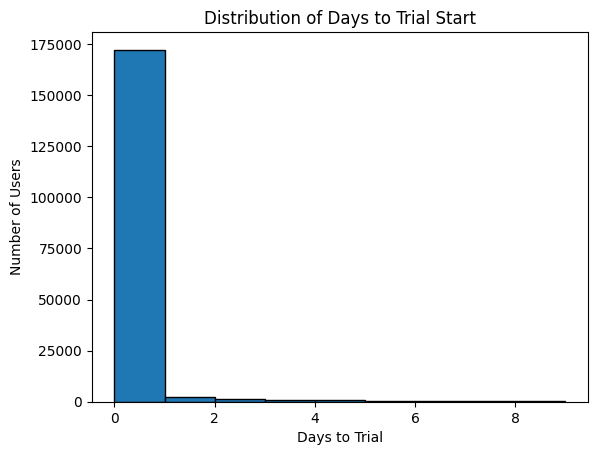

In [ ]:
# some graphs to understand business situation
# 1) Histogram of days_to_trial


plt.figure()
plt.hist(df['days_to_trial'].dropna(), bins=range(0, 10), edgecolor='black')
plt.title('Distribution of Days to Trial Start')
plt.xlabel('Days to Trial')
plt.ylabel('Number of Users')
plt.show()

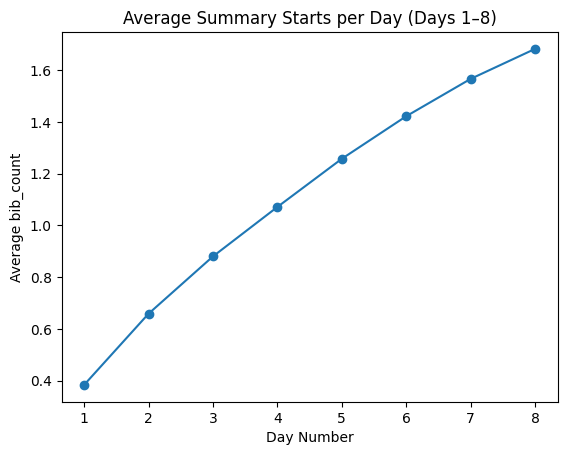

In [38]:
# 4) Average bib_count per day 1-8
bib_cols = [col for col in df.columns if col.startswith('bib_day')]
avg_bib = df[bib_cols].mean()
plt.figure()
plt.plot(range(1, len(bib_cols)+1), avg_bib.values, marker='o')
plt.title('Average Summary Starts per Day (Days 1–8)')
plt.xlabel('Day Number')
plt.ylabel('Average bib_count')
plt.xticks(range(1, len(bib_cols)+1))
plt.show()

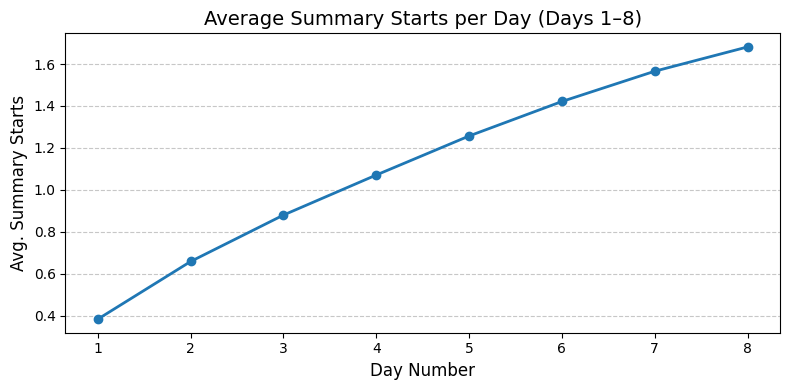

In [39]:
# 4) Average bib_count per day 1–8 (redesigned)
bib_cols = [col for col in df.columns if col.startswith('bib_day')]
avg_bib = df[bib_cols].mean().values

plt.figure(figsize=(8, 4))
plt.plot(
    range(1, len(bib_cols) + 1),
    avg_bib,
    marker='o',
    linestyle='-',
    linewidth=2,
    markersize=6
)
plt.title('Average Summary Starts per Day (Days 1–8)', fontsize=14)
plt.xlabel('Day Number', fontsize=12)
plt.ylabel('Avg. Summary Starts', fontsize=12)
plt.xticks(range(1, len(bib_cols) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


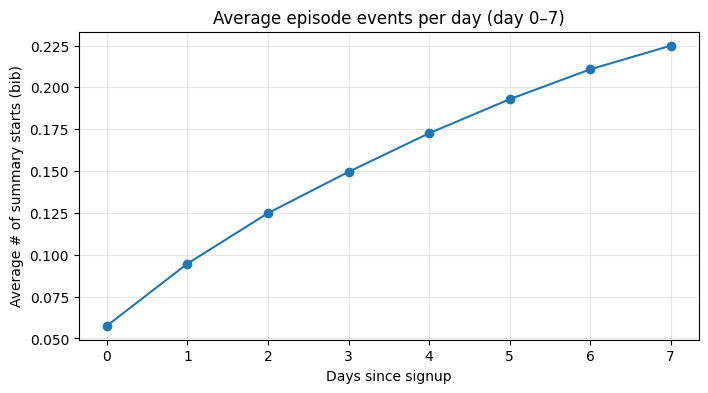

In [86]:
# 2) Line plot of the mean episode_day0 on days 0–7
days = list(range(8))
cols = [f"episode_day{d}" for d in days]
means = df[cols].mean()

plt.figure(figsize=(8,4))
plt.plot(days, means, marker='o')
plt.xticks(days)
plt.xlabel("Days since signup")
plt.ylabel("Average # of summary starts (bib)")
plt.title("Average episode events per day (day 0–7)")
plt.grid(alpha=0.3)
plt.show()

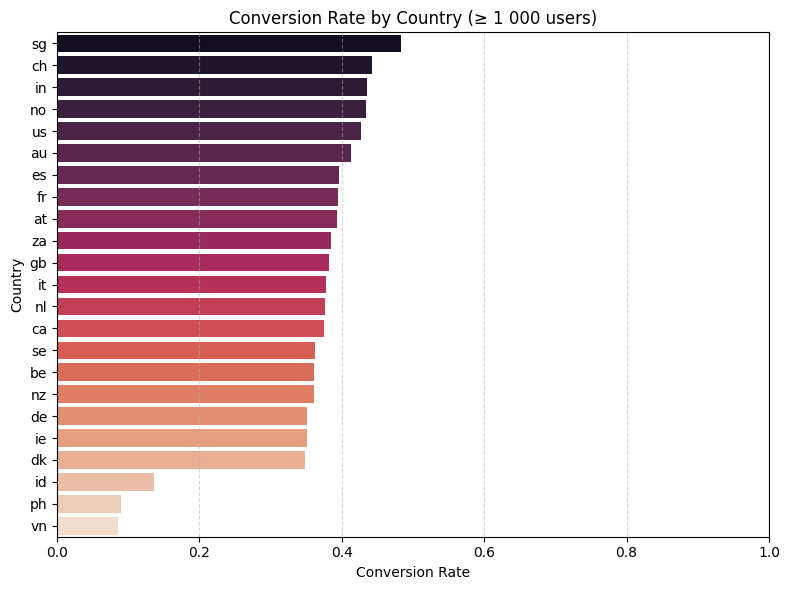

In [ ]:
# 1) compute per‐country counts & conversion
ct = df['country'].value_counts()
big_countries = ct[ct >= 1000].index            # only keep countries with ≥1k users
country_stats = (
    df[df['country'].isin(big_countries)]
      .groupby('country')['converted']
      .agg(['mean','count'])
      .rename(columns={'mean':'conv_rate','count':'n_users'})
      .sort_values('conv_rate', ascending=False)
)

# 2) horizontal bar plot
plt.figure(figsize=(8,6))
sns.barplot(
    data=country_stats.reset_index(),
    y='country', x='conv_rate',
    palette='rocket'
)
plt.title("Conversion Rate by Country (≥ 1 000 users)")
plt.xlabel("Conversion Rate %")
plt.ylabel("Country")
plt.xlim(0,1)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



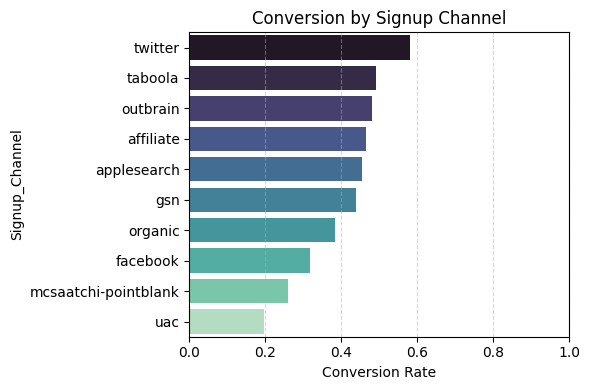

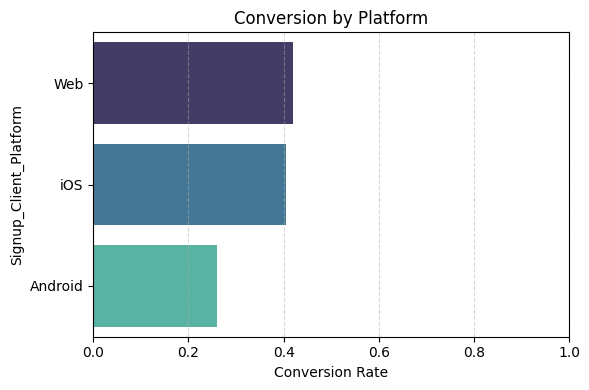

In [ ]:
def plot_cat_metric(col, min_n=500, title=None):
    stats = (
      df[col].value_counts()
        .pipe(lambda vc: vc[vc >= min_n].index)           # keep big categories
        .to_series(name='n_users')
        .reset_index().rename(columns={'index':col})
        .merge(
            df.groupby(col)['converted']
              .mean().rename('conv_rate'),
            on=col
        )
        .sort_values('conv_rate', ascending=False)
    )
    plt.figure(figsize=(6,4))
    sns.barplot(data=stats, y=col, x='conv_rate', palette='mako')
    plt.title(title or f"Conversion by {col.title()}")
    plt.xlabel("Conversion Rate %")
    plt.ylabel(col.title())
    plt.xlim(0,1)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# by signup channel
plot_cat_metric('signup_channel', min_n=2000, title="Conversion by Signup Channel")

# by client platform
plot_cat_metric('signup_client_platform', min_n=2000, title="Conversion by Platform")



In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194459 entries, 0 to 194458
Data columns (total 32 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   user_id                 194459 non-null  object        
 1   converted               194459 non-null  int32         
 2   country                 194459 non-null  object        
 3   signup_channel          194459 non-null  object        
 4   signup_client_platform  194459 non-null  object        
 5   bib_day0                194459 non-null  float64       
 6   bib_day1                194459 non-null  float64       
 7   bib_day2                194459 non-null  float64       
 8   bib_day3                194459 non-null  float64       
 9   bib_day4                194459 non-null  float64       
 10  bib_day5                194459 non-null  float64       
 11  bib_day6                194459 non-null  float64       
 12  bib_day7                194459

In [ ]:
# build a preprocessing + modeling pipeline:
# - OneHotEncoder for categorical cols (drop first category, ignore unknowns)
# - passthrough numeric cols unchanged
# - train LogisticRegression(max_iter=1000, random_state=42)
# fit on X_train/y_train, then on X_test:
# - predict_probabilities for ROC-AUC curve analysis
# - predict classes for F1 calculation
# print baseline ROC-AUC and F1 so we have initial benchmarks



N = 1                       # змінюй, якщо треба Day-2, Day-3 …
num_cols = [f'bib_day{N-1}',          # bib_day0  (при N=1)
            f'episode_day{N-1}',      # episode_day0
            f'trial_day{N}']          # trial_day1 (індикатор trial ≤24 год)


In [46]:
cat_cols = ['country', 'signup_channel', 'signup_client_platform']
target   = 'converted'


In [47]:
df_mod = df.drop(columns=['user_id',
                          'first_marketplace',   # payment info -> leakage
                          'has_mp',              # дублікат попереднього
                          'days_to_trial',
                          'trial_ts', 'signup_ts'],      # замінено trial_day
                     errors='ignore')

In [48]:
X = df_mod[cat_cols + num_cols]
y = df_mod[target]

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42)

In [50]:
preprocess = ColumnTransformer(
    [('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)],
    remainder='passthrough')

In [51]:
pipe_lr = Pipeline([
    ('prep', preprocess),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
])

In [52]:
# обчислює площу під ROC-кривою, тобто наскільки добре модель розрізняє класи на різних порогах.

pipe_lr.fit(X_train, y_train)
# Робимо прогноз ймовірностей і класів на тесті
y_prob = pipe_lr.predict_proba(X_test)[:,1]
y_pred = pipe_lr.predict(X_test)

# Обчислюємо метрики
auc = roc_auc_score(y_test, y_prob)
f1 = f1_score(y_test, y_pred)
print(f"Baseline LogisticRegression - ROC-AUC: {auc:.3f}, F1: {f1:.3f}")

Baseline LogisticRegression - ROC-AUC: 0.645, F1: 0.345


C:\Users\Pysku\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Pysku\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
# за замовчуванням для класифікатора — це accuracy (доля правильних передбачень) на тих даних, які ти передав.
# evaluate overall classifier accuracy on the full dataset:
# pipe_lr.score(X, y) returns the fraction of correct predictions
# this quick check ensures the pipeline runs end-to-end before deeper analysis

pipe_lr.score(X, y)

C:\Users\Pysku\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.6423410590407233

In [ ]:
# inspect model errors via confusion matrix

from sklearn.metrics import confusion_matrix

# y_true — справжні мітки, y_pred — це model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix:")
print(cm)
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")


Confusion Matrix:
[[21098  2792]
 [11290  3712]]
TN=21098, FP=2792, FN=11290, TP=3712


In [ ]:
# baseline summary:
# overall accuracy ~0.642, ROC-AUC ~0.645, F1 ~0.345
# confusion matrix shows more false negatives (11290) than true positives (3712)
# coeficients, which are below, in liniar model are telling us which parametr is more important

coefs = pipe_lr.named_steps['lr'].coef_[0]      # масив ваг b1…bp
features = pipe_lr.named_steps['prep'].get_feature_names_out()
pd.Series(coefs, index=features).sort_values(ascending=False).head(20)


cat__signup_channel_thoughty2              1.251660
cat__signup_channel_feli-from-germany      1.244822
cat__signup_channel_caspianreport          1.239192
cat__signup_channel_youfact-tech           1.202952
cat__signup_channel_awfnr                  1.118350
cat__signup_channel_fond                   1.089800
cat__country_ag                            1.079426
cat__signup_channel_politics-war-room      1.067392
cat__country_bm                            1.059572
cat__signup_channel_rexs-hangar            1.056648
cat__country_gl                            1.051893
cat__signup_channel_betreutes-fhlen        1.035200
cat__country_sc                            1.014879
cat__country_me                            0.982300
cat__signup_channel_the-mary-trump-show    0.965899
cat__signup_channel_politicsgirl           0.965056
cat__signup_channel_pleo                   0.960041
cat__country_pg                            0.941158
cat__country_bq                            0.940019
cat__country

In [ ]:
# I wanted a rough idea of which model was worth tuning, 
# so I looped through all three (LR, RF, XGB) and ran a 5-fold CV on just the categorical features, scoring with ROC-AUC


pipe_rf = Pipeline([
    ('prep', preprocess),
    ('rf',  RandomForestClassifier(n_estimators=1000, random_state=42))
])

pipe_xgb = Pipeline([
    ('prep', preprocess),
    ('xgb', XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=0))
])

In [ ]:
models = {
    "LogisticRegression": pipe_lr,
    "RandomForest": pipe_rf,
    "XGBoost": pipe_xgb
}
for name, pipeline in models.items():
    auc_scores = cross_val_score(pipeline, df[cat_cols], df[target],
                                 cv=5, scoring='roc_auc')
    print(f"{name} ROC-AUC: {auc_scores.mean():.3f} ± {auc_scores.std():.3f}")

C:\Users\Pysku\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Pysku\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Pysku\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Pysku\AppData\Local

LogisticRegression ROC-AUC: 0.615 ± 0.003


In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(pipe_xgb, X_test, y_test, n_repeats=10, scoring='roc_auc')
imp = pd.Series(result.importances_mean, index=X_test.columns).sort_values(ascending=False)
imp.head(20)


signup_channel            0.048635
signup_client_platform    0.040663
country                   0.040532
bib_day0                  0.032875
trial_day1                0.032713
episode_day0              0.001876
dtype: float64

In [ ]:
pipelines = {
    'logreg': pipe_lr,
    'rf':      pipe_rf,
    'xgb':     pipe_xgb
}


In [ ]:
pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['country', 'signup_channel',
                                                   'signup_client_platform'])])),
                ('rf',
                 RandomForestClassifier(n_estimators=1000, random_state=42))])

C:\Users\Pysku\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Pysku\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Pysku\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Pysku\AppData\Local

<Axes: title={'center': 'Perm Importances by Model'}>

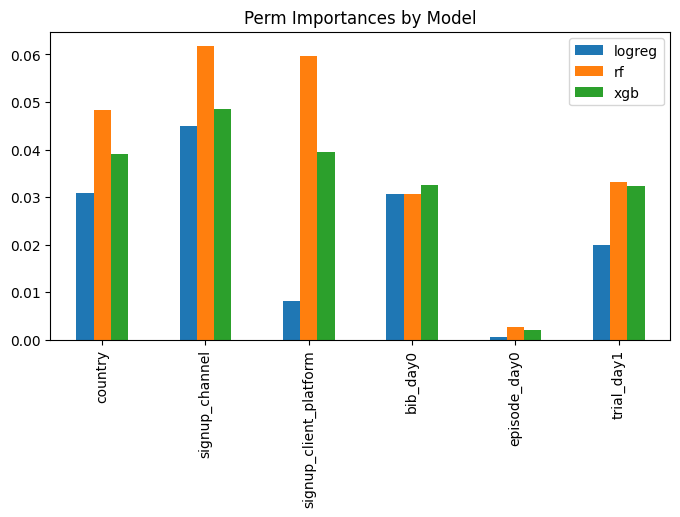

In [ ]:
from sklearn.inspection import permutation_importance

all_imps = {}
for name, pipe in pipelines.items():
    res = permutation_importance(pipe, X_test, y_test,
                                 n_repeats=10,
                                 scoring='roc_auc',
                                 random_state=42)
    all_imps[name] = pd.Series(res.importances_mean, index=X_test.columns)

imp_df = pd.DataFrame(all_imps)
imp_df.sort_values(by='xgb', ascending=False).head(10)
# або навіть:
imp_df.plot.bar(figsize=(8,4), title="Perm Importances by Model")


In [ ]:
# we added two new models to the pipeline: RandomForest with 1000 trees and XGBoost with 100 boosting rounds, use_label_encoder=False and eval_metric='logloss'
# both models use the same one-hot + passthrough preprocessing and slot right in after our logistic regression
# next weI ran a quick 5-fold cross-validation on the categorical features only, scoring with ROC-AUC to see which model looks most promising
# the results showed RF and XGBoost outperforming logistic regression (around 0.62 vs 0.615)
# then we did a permutation importance analysis: fit each model on the training set, shuffled each feature 10 times on the test set and measured the drop in ROC-AUC
# this gave me an average importance score for every feature in each model
# finally we plotted the importances side by side and saw that signup_channel, signup_client_platform and country are the top predictors, followed by bib_day0, trial_day1 and episode_day0
# these insights point the way forward: engineer deeper features around those top signals, tune RF/XGBoost hyperparameters, or test new algorithms for extra gains


In [ ]:
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # X: DataFrame із категоріальними стовпцями
        self.maps_ = {
            col: X[col].value_counts(normalize=True).to_dict()
            for col in X.columns
        }
        return self

    def transform(self, X):
        X2 = X.copy()
        for col, fmap in self.maps_.items():
            X2[col] = X2[col].map(fmap).fillna(0.0)
        return X2

In [ ]:
# I wrote a sklearn-style FrequencyEncoder to map high-cardinality columns (country, signup_channel) to their relative frequencies and used OneHotEncoder for low-cardinality columns (signup_client_platform)
# then I built a ColumnTransformer that applies ‘freq’ to the high-cardinality set and ‘ohe’ to the low-cardinality set, passing through all other features
# finally I wrapped that transformer and an XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=0) into one Pipeline
# now I have a clean, end-to-end preprocessing + modeling workflow that handles both many and few categories seamlessly

N = 2


num_cols = [f'bib_day{N-1}',          # bib_day0  (при N=1)
            f'episode_day{N-1}',      # episode_day0
            f'trial_day{N-1}',
            f'trial_day{N}']          # trial_day1 (індикатор trial ≤24 год)


cat_high = ['country', 'signup_channel']
cat_low  = ['signup_client_platform']

In [60]:
preprocess_tuned = ColumnTransformer([
    # частотне кодування для high-cardinality
    ('freq', FrequencyEncoder(), cat_high),
    # one-hot для low-cardinality
    ('ohe', OneHotEncoder(drop=None, handle_unknown='ignore'), cat_low),
],
remainder='passthrough'  # усі інші стовпці залишаємо як є
)

pipe_xgb = Pipeline([
    ('prep', preprocess_tuned),
    ('xgb', XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=0))
])

In [61]:
pipe_xgb.fit(X_train, y_train)
# Робимо прогноз ймовірностей і класів на тесті
y_prob = pipe_xgb.predict_proba(X_test)[:,1]
y_pred = pipe_xgb.predict(X_test)

C:\Users\Pysku\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [18:06:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
# I set up a 5-fold StratifiedKFold CV with scoring={'roc_auc','f1','accuracy'} and ran cross_validate on the XGB pipeline over X,y
# this gave me reliable baseline metrics: ROC-AUC ~0.666±0.003, F1 ~0.380±0.003, Accuracy ~0.649±0.000
# seeing these numbers confirmed that the pipeline architecture is solid and worth tuning before moving further

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'roc_auc':  'roc_auc',
    'f1':       'f1',
    'accuracy': 'accuracy'
}

cv_res = cross_validate(
    pipe_xgb,
    X, y,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)


print(f"\n=== Cross-validation results (5-fold) ===")
for metric in scoring:
    scores = cv_res[f'test_{metric}']
    print(f"{metric.upper():9s}: {scores.mean():.3f} ± {scores.std():.3f}")

C:\Users\Pysku\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [18:06:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Pysku\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [18:06:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Pysku\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [18:06:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } 


=== Cross-validation results (5-fold) ===
ROC_AUC  : 0.666 ± 0.003
F1       : 0.380 ± 0.003
ACCURACY : 0.649 ± 0.000


In [64]:
pipe_xgb_tuned = Pipeline([
    ('prep', preprocess_tuned),
    ('xgb', XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=0))
])

In [65]:
# 1) Задаємо простір гіперпараметрів
param_dist = {
    'xgb__n_estimators':     [100, 300, 500, 800],
    'xgb__max_depth':        [3, 5, 7, 9],
    'xgb__min_child_weight': [1, 3, 5],
    'xgb__gamma':            [0, 0.5, 1, 5],
    'xgb__subsample':        [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__learning_rate':    [0.01, 0.05, 0.1, 0.2],
    'xgb__reg_alpha':        [0, 0.1, 1, 5],
    'xgb__reg_lambda':       [1, 5, 10]
}

In [66]:
# 2) Налаштовуємо CV-схему
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# 3) Створюємо RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=pipe_xgb_tuned,
    param_distributions=param_dist,
    n_iter=30,               # кількість випадкових комбінацій
    scoring='roc_auc',       # оптимізуємо ROC-AUC
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

In [ ]:

search.fit(X_train, y_train)


print("Best CV ROC-AUC:     ", search.best_score_)
print("Best hyperparameters:", search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\Pysku\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [18:18:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best CV ROC-AUC:      0.6662856258855132
Best hyperparameters: {'xgb__subsample': 0.6, 'xgb__reg_lambda': 10, 'xgb__reg_alpha': 0, 'xgb__n_estimators': 300, 'xgb__min_child_weight': 1, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.05, 'xgb__gamma': 0.5, 'xgb__colsample_bytree': 0.8}


In [69]:
# 6) Оцінюємо на тесті
best_pipe = search.best_estimator_
y_prob = best_pipe.predict_proba(X_test)[:,1]
y_pred = best_pipe.predict(X_test)

from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
print("Test ROC-AUC: ", roc_auc_score(y_test, y_prob))
print("Test F1:      ", f1_score   (y_test, y_pred))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Test ROC-AUC:  0.6660937241296527
Test F1:       0.37785341502155656
Test Accuracy: 0.6475110562583565


In [70]:
pipe_xgb_tuned = Pipeline([
    ('prep', preprocess),
    ('xgb', XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=0))
])

In [71]:
# 1) Задаємо простір гіперпараметрів
param_dist = {
    'xgb__n_estimators':     [100, 300, 500, 800],
    'xgb__max_depth':        [3, 5, 7, 9],
    'xgb__min_child_weight': [1, 3, 5],
    'xgb__gamma':            [0, 0.5, 1, 5],
    'xgb__subsample':        [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__learning_rate':    [0.01, 0.05, 0.1, 0.2],
    'xgb__reg_alpha':        [0, 0.1, 1, 5],
    'xgb__reg_lambda':       [1, 5, 10]
}

In [72]:
# 2) Налаштовуємо CV-схему
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# 3) Створюємо RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=pipe_xgb_tuned,
    param_distributions=param_dist,
    n_iter=30,               # кількість випадкових комбінацій
    scoring='roc_auc',       # оптимізуємо ROC-AUC
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

In [74]:
# 4) Запускаємо пошук
search.fit(X_train, y_train)

# 5) Виводимо результати
print("Best CV ROC-AUC:     ", search.best_score_)
print("Best hyperparameters:", search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\Pysku\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [18:46:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best CV ROC-AUC:      0.6671430498265438
Best hyperparameters: {'xgb__subsample': 0.8, 'xgb__reg_lambda': 5, 'xgb__reg_alpha': 0, 'xgb__n_estimators': 500, 'xgb__min_child_weight': 3, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.05, 'xgb__gamma': 1, 'xgb__colsample_bytree': 1.0}


In [75]:
# 6) Оцінюємо на тесті
best_pipe = search.best_estimator_
y_prob = best_pipe.predict_proba(X_test)[:,1]
y_pred = best_pipe.predict(X_test)

from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
print("Test ROC-AUC: ", roc_auc_score(y_test, y_prob))
print("Test F1:      ", f1_score   (y_test, y_pred))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

C:\Users\Pysku\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Pysku\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Test ROC-AUC:  0.6669182535115032
Test F1:       0.37697907188353047
Test Accuracy: 0.6478967396893963


In [ ]:

# I defined a hyperparameter space for XGB (n_estimators, max_depth, learning_rate, gamma, subsample, colsample_bytree, reg_alpha, reg_lambda)
# then ran RandomizedSearchCV(pipe_xgb_tuned, param_distributions=param_dist, n_iter=30, scoring='roc_auc', cv=cv, random_state=42)
# after ~150 fits I printed best_score_ and best_params_, evaluated the best estimator on the test set (roc_auc_score, f1_score, accuracy_score)
# finally I plotted the Day-2 feature gains chart and saw top drivers like signup_channel_uac, signup_client_platform_iOS, country_us, bib_day0 and trial_day1

onehotencoding
Test ROC-AUC:  0.6669182535115032
Test F1:       0.37697907188353047
Test Accuracy: 0.6478967396893963
Best CV ROC-AUC:      0.6671430498265438
Best hyperparameters: {'xgb__subsample': 0.8, 'xgb__reg_lambda': 5, 'xgb__reg_alpha': 0, 'xgb__n_estimators': 500, 'xgb__min_child_weight': 3, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.05, 'xgb__gamma': 1, 'xgb__colsample_bytree': 1.0}


freequent
Test ROC-AUC:  0.6660937241296527
Test F1:       0.37785341502155656
Test Accuracy: 0.6475110562583565
Best CV ROC-AUC:      0.6662856258855132
Best hyperparameters: {'xgb__subsample': 0.6, 'xgb__reg_lambda': 10, 'xgb__reg_alpha': 0, 'xgb__n_estimators': 300, 'xgb__min_child_weight': 1, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.05, 'xgb__gamma': 0.5, 'xgb__colsample_bytree': 0.8}



C:\Users\Pysku\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [02:05:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


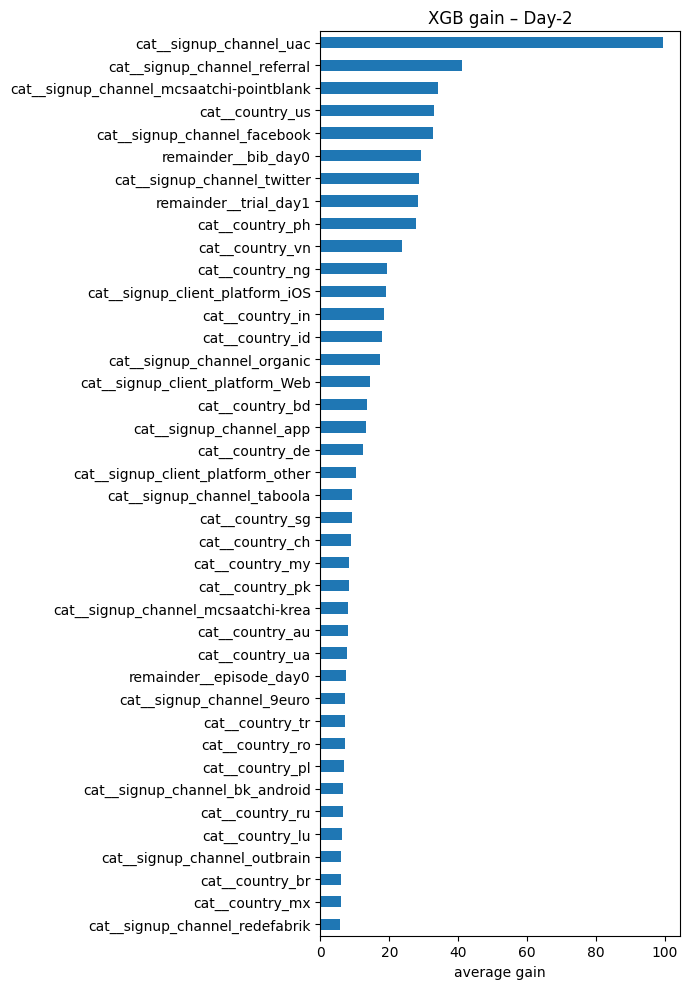

In [87]:
pipe_xgb_best = Pipeline([
    ('prep', preprocess),
    ('xgb',  XGBClassifier(
                 n_estimators=500, max_depth=7, learning_rate=0.05, reg_alpha = 0,
                 subsample=0.8, colsample_bytree=1, min_child_weight = 3,
                 random_state=42, eval_metric='logloss', gamma = 1, reg_lambda = 5,
                 use_label_encoder=False))
])

pipe_xgb_best.fit(X_train, y_train)

# важливості
booster = pipe_xgb_best.named_steps['xgb'].get_booster()
gain = pd.Series(booster.get_score(importance_type='gain'))
feat_names = pipe_xgb_best.named_steps['prep'].get_feature_names_out()
feat_gain = gain.rename(index=lambda f: feat_names[int(f[1:])]).sort_values(ascending=False)

feat_gain.head(40).iloc[::-1].plot(kind='barh', figsize=(7,10))
plt.title(f"XGB gain – Day-{N}")
plt.xlabel("average gain"); plt.tight_layout(); plt.show()